## Regla de Simpson -Computo paralelo con Dask

In [1]:
#Importamos las librerias
import math
import time
import multiprocessing
import numpy as np
from dask.distributed import Client
from scipy.integrate import quad

/Users/pozoshidalgo/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/pozoshidalgo/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
f=lambda x: np.exp(-x**2) #Función a aproximar
a=0
b=1
n=10**6
h_hat=(b-a)/n

### Forma secuencial

In [3]:
def Scf(n,f,a,b): #algoritmo1
    """
    Compute numerical approximation using trapezoidal rule in 
    an interval.
    Nodes are generated via numpy
    Args:
        f (lambda expression): lambda expression of integrand
        a (int): left point of interval
        b (int): right point of interval
        n (int): number of subintervals 
    """
    h = b-a
    h_hat=h/n
    nodes=[a+(i)*h_hat for i in range(0,n+1)]
    sum_res1=sum(f(np.asarray(nodes[2:n:2])))
    sum_res2=sum(f(np.asarray(nodes[1:n:2])))
    return h/(3*n)*(f(nodes[0])+f(nodes[-1])+2*sum_res1+4*sum_res2)

In [4]:
start_time = time.time()
aprox=Scf(n,f,a,b)
end_time = time.time()

In [5]:
secs = end_time-start_time
print("Scf tomó",secs,"segundos" )

Scf tomó 0.49489808082580566 segundos


In [6]:
obj, err = quad(f, a, b)

In [7]:
def err_relativo(aprox, obj):
    return math.fabs(aprox-obj)/math.fabs(obj) #obsérvese el uso de la librería math

In [8]:
err_relativo(aprox,obj)

6.392347001308277e-15

In [9]:
Scf_secuencial_timeit = %timeit -n 5 -r 10 -o Scf(n,f,a,b)

382 ms ± 22.2 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [10]:
def Scf_2(n,f,a,b):   #algoritmo 2
    h_hat = (b-a)/(n)
    suma = f(a) + f(b)
    for i in range(1,n,1):
        if(i%2 ==0):
            suma += (2*(f(a + i*h_hat)))
        else:
            suma += (4*(f(a + i*h_hat)))
    suma *= (h_hat/3.0)
    return suma

In [11]:
start_time = time.time()
aprox=Scf_2(n,f,a,b)
end_time = time.time()

In [12]:
secs = end_time-start_time
print("Scf tomó",secs,"segundos" )

Scf tomó 2.927259683609009 segundos


In [13]:
obj, err = quad(f, a, b)

In [14]:
err_relativo(aprox,obj)

3.434028272795842e-14

In [15]:
Scf_secuencial_timeit = %timeit -n 5 -r 10 -o Scf_2(n,f,a,b)

3.01 s ± 39.9 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


El primer algoritmo es mejor porque tanto su tiempo de ejecución y su error relativo son más pequeños.

### Forma paralelo

De forma sencilla se puede ver que la regla compuesta de Simpson compuesta $S_c(f)$ se escribe como:

$$S_c(f) = \displaystyle \frac{h}{3n} \left [ f(x_0) + f(x_n) + 2 \sum_{i=1}^{\frac{n}{2}-1}f(x_{2i}) + 4 \sum_{i=1}^{\frac{n}{2}}f(x_{2i-1})\right ] $$
con $h=b-a$ y $n$ número de subintervalos (par).

Nota: Los nodos para el caso de Simpson se obtienen con la fórmula: $x_i = a +\frac{i}{2}\hat{h}, \forall i=0,\dots,2n, \hat{h}=\frac{h}{n}$.

In [16]:
p=multiprocessing.cpu_count()
ns_p = int(n/p) 
ns_p #Cada core hace 250,000 intervalos para calcular la integral

250000

In [17]:
client = Client()

In [18]:
def construye_nodos_en_subintervalos(mi_id,a,b,h_hat,n,ns_p):
    h_hat=(b-a)/n
    #nodos = []
    nodos_par = []
    nodos_non = []
    for i in range(0,n):
        #nodos.append(a+(i+1/2.0)*h_hat)
        if i%2==0:
            nodos_par.append(a+i*h_hat)
        else:
            nodos_non.append(a+i*h_hat)
    return nodos_par, nodos_non

In [19]:
def evalua_f_en_nodos_y_suma_pares(nodos_par,f):
    suma_res1 = 0
    for nodo in nodos_par[0]:
        suma_res1+=f(nodo)*2
    return suma_res1

In [20]:
def evalua_f_en_nodos_y_suma_nones(nodos_non,f):
    suma_res2 = 0
    for nodo in nodos_non[1]:
        suma_res2+=f(nodo)*2
    return suma_res2

In [21]:
%%time
futures_nodos = client.map(construye_nodos_en_subintervalos,range(p),
                                                            **{'a':a,
                                                               'b':b,
                                                               'h_hat':h_hat,
                                                               'n':n,
                                                               'ns_p':ns_p}
                            )
futures_evalua_pares = client.map(evalua_f_en_nodos_y_suma_pares, futures_nodos,
                                                       **{'f':f,}
                            )
futures_evalua_nones = client.map(evalua_f_en_nodos_y_suma_nones, futures_nodos,
                                                       **{'f':f,}
                            )
results_pares= client.gather(futures_evalua_pares)
results_nones= client.gather(futures_evalua_nones)
results=results_pares+results_nones
aprox=h_hat*sum(results)/3

CPU times: user 959 ms, sys: 407 ms, total: 1.37 s
Wall time: 20.3 s


In [22]:
err_relativo(aprox,obj)

3.434028272795842e-14

In [23]:
client.close()

### Gráfica tiempo de ejecución vs num procesos

In [24]:
multiprocessing.cpu_count()
#En esta máquina se estan utilizando 4 cores

4

In [25]:
err_np=[]
n_cpus=[]

In [26]:
def Scf_parallel(mi_id,f,a,b,h_hat,n,ns_p):
    """
    Compute numerical approximation using Simpson rule in an interval
    Nodes are generated via formula: x_i = a+i/2*h_hat for i=0,1,...,2n and h_hat=(b-a)/n
    n must be an even number
    Args:
        mi_id (in): id of subprocess: 0,1,2,...
    """
    begin = (mi_id*ns_p)+1
    print("id")
    print(mi_id)
    print("begin")
    print(begin)
    end = begin-1+ns_p
    print("end")
    #print(end)
    sum1=0
    #next for loop considers sum that is multiplied by 4 in the expression
    for i in range(begin,end+1,2):
        x = a+i/2*h_hat
        sum1+=f(x)
    sum1=4*sum1
    #print(sum1)
    sum2=0
    #next for loop considers sum that is multiplied by 2 in the expression
    for i in range(begin+1,end+1,2):
        x = a+i/2*h_hat
        sum2+=f(x)
    sum2=2*sum2
    #print(sum2)
    return sum1+sum2

In [27]:
def mifun(cl,p,ns_p):
    futures_Scf_parallel = cl.map(Scf_parallel,range(p),
                                             **{'f':f,
                                                'a':a,
                                                'b':b,
                                                'h_hat':h_hat,
                                                'n':n,
                                                'ns_p':ns_p}
                              ) 
    results = cl.gather(futures_Scf_parallel)
    aprox = h_hat*sum(results)
    return err_relativo(aprox,obj)

In [28]:
client.close()

In [29]:
client

Client Scheduler: tcp://127.0.0.1:53417 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [ ]:
for p in range(1,multiprocessing.cpu_count()+1):
    if n%p==0:
        ns_p=int(n/p)
        client = Client(n_workers=p,
                        threads_per_worker=1
                       )
        err_np.append(mifun(client,p,ns_p))
        n_cpus.append(p)
        client.close()

In [31]:
err_np

[2.7059405229112166, 2.705940522911138, 2.7059405229111144]

In [32]:
n_cpus

[1, 2, 4]

In [33]:
l=[]
n_cpus=[]

In [34]:
client.close()

In [35]:
client

Client Scheduler: tcp://127.0.0.1:65051 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.29 GB


In [36]:
for p in range(1,multiprocessing.cpu_count()+1):
    if n%p==0:
        ns_p=int(n/p)
        client = Client(n_workers=p,
                threads_per_worker=1
               )
        futures_Scf_parallel = client.map(Scf_parallel,range(p),
                                          **{'f':f,
                                             'a':a,
                                             'b':b,
                                             'h_hat':h_hat,
                                             'n':n,
                                             'ns_p':ns_p}
                                         )
        resultado_timeit=%timeit -n 1 -r 1 -o client.gather(futures_Scf_parallel)
        l.append(resultado_timeit.average)
        n_cpus.append(p)
        client.close()

2.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [37]:
l

[2.6832750309999938, 1.4211168770000313, 1.5092063219999545]

In [38]:
n_cpus

[1, 2, 4]

In [39]:
import matplotlib.pyplot as plt

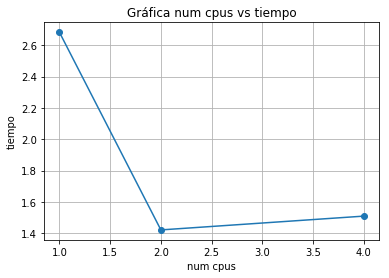

In [40]:
plt.plot(n_cpus,l,'o-')
plt.title('Gráfica num cpus vs tiempo')
plt.xlabel('num cpus')
plt.ylabel('tiempo')
plt.grid()
plt.show()